In [33]:
from bs4 import BeautifulSoup
import sqlite3
import requests
import pandas as pd
from random import randint
import time
from time import sleep
from typing import List
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score
from scipy.stats import spearmanr

In [41]:
def sleepms(milliseconds: int):
    seconds = 0.001 * milliseconds
    sleep(seconds)
    
def random_wait():
    start = time.time()
    sleepms(randint(1, 350))

def getFakeUser():
    return {"User-Agent":"PostmanRuntime/7.29.0"}


def getRetHeaders():
    url='https://www.ret.co.il/m/91935/specs'
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    data=product.findAll('ul','list-group list-group-horizontal')
    myheaders= ['מחיר מינימלי','מחיר מקסימלי']
    for alldata in data:
        myheaders.append(alldata.find('span',class_='text-dark font-weight-bold').text.strip())
    return myheaders


def getUrl(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('ul', class_='nav nav-pills mb-2 justify-content-around justify-content-md-start col-xxl-10 offset-xxl-1 col-md-12 offset-md-0')
    ref=[]
    data=MainClass.find('a')
    technicalDataPage='https://www.ret.co.il'+data.get('href')
    return technicalDataPage

def getRetData(url):
    technicalDataPage=getUrl(url)
    page = requests.get(technicalDataPage, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    product=soup.find('div',class_='single-product-tab')
    dataLink=product.findAll('ul',class_='list-group list-group-horizontal')
    MinMaxP=MinMaxRetPrices(url)
    mydata=[MinMaxP[0],MinMaxP[1]]
    myheaders=[]
    for alldata in dataLink:
        try:
            mydata.append(alldata.find('li',class_='list-group-item col-8 rounded-0 text-600').text.strip())
        except:
             mydata.append('None')
    return mydata

def MinMaxRetPrices(url):
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.find('div',class_='')
    MainClass=soup.find('div',class_='card-body p-0 p-sm-3')
    price=MainClass.find('div',class_='price')
    if(price==None):
        return [None,None]
    else:
        price=price.text.strip()
        price=price.replace(',','')
        prices=price.split()
        MinPrice=prices[0]
        MaxPrice=prices[3]
        priceArray=MinPrice,MaxPrice
        return priceArray


In [42]:
def getRetToDataFrame(phonesURL):
    hrefLinks=[]
    allRetData=[]
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    MainClass=soup.findAll('a')
    for href in MainClass:
        if('/m/' in href.get('href')):
            hrefLinks.append('https://www.ret.co.il' + href.get('href'))
    for hrefLink in hrefLinks:
        allRetData.append(getRetData(hrefLink))
    return allRetData


In [43]:
def mainFunc(page_num_ret):
    head=getRetHeaders()
    url=f"https://www.ret.co.il/shop/cellphone?pageindex={page_num_ret}"
    data=getRetToDataFrame(url)
    df=pd.DataFrame(data,columns=head)
    return df

In [ ]:
df_ret=mainFunc(1)
for i in range(2,10):
    df_ret=df_ret.append(mainFunc(i))
    random_wait()

In [ ]:
def get_headers():
    url="https://www.zap.co.il/compmodels.aspx?modelid=1142728"
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    All_headers=['מחיר מינימלי','מחיר מקסימלי']
    headers=soup.find_all('div',class_="detailsRow")
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
    return All_headers


In [ ]:
def get_properites_from_link(url):
    All_data=[]
    All_headers=[]
    page = requests.get(url, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    headers=soup.find_all('div',class_="detailsRow")
    titles = ['מחיר מינימלי','מחיר מקסימלי']
    prices = soup.find('div','PricesTxt').findAll('span') 
    if len(prices) == 2:
        All_data = [ prices[1].text, prices[0].text ]
    elif len(prices) == 1: 
        All_data = [ prices[0].text, prices[0].text ]
    else:
        All_data = [ None,None ]
    for header in headers:
        All_headers.append(header.find('div',class_="detailsRowTitletxt").text.strip())
        All_data.append(header.find('div',class_="detailsRowTxt").text.strip())
    return All_data

In [ ]:
def get_data_from_zap(phonesURL):
    hrefLinks=[]
    all_zap_Data=[]
    Main_Url="https://www.zap.co.il"
    page = requests.get(phonesURL, headers = getFakeUser())
    soup= BeautifulSoup(page.content,'html.parser')
    links=soup.find_all('div',class_="MoreInfo")
    for link in links:
        hrefLinks.append(Main_Url+(link.find('a')['href']))
    for link in hrefLinks:
        all_zap_Data.append(get_properites_from_link(link))
    return all_zap_Data
    

In [ ]:
def get_details_from_current_page(page_num_zap):
    url="https://www.zap.co.il/models.aspx?sog=e-cellphone&pageinfo={page_num_zap}"
    data=get_data_from_zap(url)
    df=pd.DataFrame(data,columns=get_headers())
    return df


Changing all the headers in the DataFrame from Hebrew to English

In [ ]:

def change_CSV_File_Headers(df):
    df.rename(columns={"פוקוס אוטומטי": "Autofocus"}, inplace=True)
    df.rename(columns={"פלאש": "Flash"}, inplace=True)
    df.rename(columns={"מצלמה": "Camera"}, inplace=True)
    df.rename(columns={"מפעיל": "operator"}, inplace=True)
    df.rename(columns={"דור": "Generation"}, inplace=True)
    df.rename(columns={"סוג רשת": "Network kind"}, inplace=True)
    df.rename(columns={"כרטיס SIM": "SIM"},inplace=True)
    df.rename(columns={"רדיו FM": "FM radio"}, inplace=True)
    df.rename(columns={"גובה": "height"}, inplace=True)
    df.rename(columns={"רוחב": "width"}, inplace=True)
    df.rename(columns={"עובי": "thickness"}, inplace=True)
    df.rename(columns={"משקל": "wheight"}, inplace=True)
    df.rename(columns={"קיבולת סוללה": "Battery capacity"}, inplace=True)
    df.rename(columns={"סוללה נשלפת": "Removable battery"}, inplace=True)
    df.rename(columns={"רמקול חיצוני": "External speaker"}, inplace=True)
    df.rename(columns={"חיבור 3.5": "connection 3.5"},inplace=True)
    df.rename(columns={"מחיר מינימלי": "Minprice"}, inplace=True)
    df.rename(columns={"מחיר מקסימלי": "Maxprice"}, inplace=True)
    df.rename(columns={"יצרן": "Brand"}, inplace=True)
    df.rename(columns={"שנת הכרזה": "Declaration year"}, inplace=True)
    df.rename(columns={"מערכת הפעלה": "Operating System"}, inplace=True)
    df.rename(columns={"סדרה": "series"}, inplace=True)
    df.rename(columns={"מבנה המכשיר": "device structure"},inplace=True)
    df.rename(columns={"ממשק הפעלה": "operating interfaceo"}, inplace=True)
    df.rename(columns={"נפח אחסון פנימי": "Internal storage volume"}, inplace=True)
    df.rename(columns={"ערכת שבבים": "chipset"}, inplace=True)
    df.rename(columns={"צבעים": "colors"}, inplace=True)
    df.rename(columns={"טלפון כשר": "kosher phone"}, inplace=True)
    df.rename(columns={"רמת קרינה (SAR)": "radiation level"}, inplace=True)
    df.rename(columns={"טלפון למבוגרים": "Phone for adults"}, inplace=True)
    df.rename(columns={"מאיץ גרפי": "Graphics accelerator"}, inplace=True)
    df.rename(columns={"מהירות מעבד": "CPU speed"},inplace=True)
    df.rename(columns={"עמידות במים": "Water resistance"}, inplace=True)
    df.rename(columns={"קורא טביעת אצבע": "Fingerprint reader"},inplace=True)
    df.rename(columns={"גודל מסך": "screen size"}, inplace=True)
    df.rename(columns={"סוג מסך": "screen type"}, inplace=True)
    df.rename(columns={"קצב רענון": "refresh rate"}, inplace=True)
    df.rename(columns={"צפיפות פיקסלים": "Pixel density"}, inplace=True)
    df.rename(columns={"מפתח צמצם": "Aperture key"}, inplace=True)
    df.rename(columns={"מעבד": "Processor"}, inplace=True)
    df.rename(columns={"רזולוציה": "resolution"},inplace=True)
    df.rename(columns={"כרטיס זיכרון":"Memory Card"}, inplace=True)
    df.rename(columns={"זיכרון RAM": "RAM memory"}, inplace=True)
    df.rename(columns={"וידאו": "video"}, inplace=True)
    df.rename(columns={"קיבולת הסוללה": "battery capacity"}, inplace=True)
    df.rename(columns={"מספר ליבות": "number of cores"}, inplace=True)
    df.rename(columns={"מצלמה קדמית": "front camera"}, inplace=True)
    df.rename(columns={"טעינה אלחוטית": "wireless charging"}, inplace=True)
    df.to_csv("PhonesDF.csv",index=False)


In [ ]:
df_zap=get_details_from_current_page(1)
for i in range(2,21):
    df_zap=df_zap.append(get_details_from_current_page(i))
    random_wait()

Saving the first DataFrame before cleaning

In [ ]:
def SaveDataFrame(df):
    df=df_zap.append(df_ret)
    df.to_csv('PhonesDF.csv',header=True)
    df=pd.read_csv('PhonesDF.csv')
    change_CSV_File_Headers(df)
    df=pd.read_csv('PhonesDF.csv')
    df


Function to clean all the Data Frame None price columns

In [86]:
def CleanTheDF(df):
    df=df.drop_duplicates()
    df.dropna(axis=0, how='all')# if all the values are None remove this row
    df=df.dropna(subset=['Minprice','Maxprice'],how ='all')
    df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
    df.to_csv('SmallPhonesDF.csv')
    return df

In [87]:
df=pd.read_csv('PhonesDF.csv')
Smalldf=CleanTheDF(df)
Smalldf

,Minprice,Maxprice,Brand,Operating System,Declaration year,device structure,series,Smartphone,radiation level,operating interfaceo,...,External speaker,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM
0,"3,458","4,649",Samsung,Android,2022,פאבלט,Galaxy S22,סמארטפון,1.05 W/kg,מסך מגע,...,זוג רמקולים,יעודכן בקרוב,"163.3 מ""מ","77.9 מ""מ","8.9 מ""מ",228 גרם,"5,000 mAh",לא,כולל,NaN
1,"2,774","3,499",Apple,iOS,2021,פאבלט,iPhone 13,סמארטפון,יעודכן בקרוב,מסך מגע,...,זוג רמקולים,ללא רדיו,"146.7 מ""מ","71.5 מ""מ","7.7 מ""מ",174 גרם,לא זמין,לא,כולל,NaN
2,"5,795","6,699",Apple,iOS,2022,פאבלט,iPhone 14 Pro Max,סמארטפון,לא זמין,מסך מגע,...,זוג רמקולים,ללא רדיו,"160.7 מ""מ","77.6 מ""מ","7.9 מ""מ",240 גרם,לא זמין,לא,כולל,NaN
3,"1,510","1,949",Samsung,Android,2022,פאבלט,Galaxy A73,סמארטפון,1.28 W/kg,מסך מגע,...,יחיד,יעודכן בקרוב,"163.7 מ""מ","76.1 מ""מ","7.6 מ""מ",181 גרם,"5,000 mAh",לא,ללא,NaN
4,"3,193","3,965",Apple,iOS,2022,פאבלט,iPhone 14,סמארטפון,לא זמין,מסך מגע,...,זוג רמקולים,ללא רדיו,"146.7 מ""מ","71.5 מ""מ","7.8 מ""מ",172 גרם,לא זמין,לא,כולל,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,1899,1899,Samsung,Android,None,פאבלט,None,סמארטפון,None,מסך מגע,...,יחיד,None,"163.7 מ""מ","76.1 מ""מ","7.6 מ""מ",181 גרם,"5,000 mAh",לא,None,None
880,1180,1180,Samsung,Android,2021,פאבלט,Galaxy A52,סמארטפון,1.05 W/kg,מסך מגע,...,זוג רמקולים,כולל רדיו,"159.9 מ""מ","75.1 מ""מ","8.4 מ""מ",189 גרם,"4,500 mAh",לא,None,None
881,5949,5949,Samsung,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
882,1799,1449,Xiaomi,Android,None,פאבלט,None,סמארטפון,None,מסך מגע,...,זוג רמקולים,None,"164.2 מ""מ","76.1 מ""מ","8.1 מ""מ",202 גרם,"5,000 mAh",לא,ללא,כולל


Cleaning and converting to Numeric

In [88]:
def cleaning_to_numeric(df):
    df['radiation level']=pd.to_numeric(df['radiation level'].str.replace('W/kg','').str.strip(),errors='coerce')
    df['height']=pd.to_numeric(df['height'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['Internal storage volume']=pd.to_numeric(df['Internal storage volume'].str.replace('GB','').str.replace('1TB','1000').str.strip(),errors='coerce')
    df['RAM memory']=pd.to_numeric(df['RAM memory'].str.replace('GB','').str.strip(),errors='coerce')
    df['width']=pd.to_numeric(df['width'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['thickness']=pd.to_numeric(df['thickness'].str.replace('מ"מ','').str.strip(),errors='coerce')
    df['wheight']=pd.to_numeric(df['wheight'].str.replace('גרם','').str.strip(),errors='coerce')
    df['refresh rate']=pd.to_numeric(df['refresh rate'].str.replace('Hz','').str.strip(),errors='coerce')
    df['Pixel density']=pd.to_numeric(df['Pixel density'].str.replace('ppi','').str.strip(),errors='coerce')
    df['number of cores']=df['number of cores'].apply(lambda x: x.removesuffix(' ליבות') if x else None) 
    df['screen size']=pd.to_numeric(df['screen size'].str.replace('אינטש','').str.strip(),errors='coerce')
    df['Network kind']=pd.to_numeric(df['Network kind'].str.replace('G','').str.strip(),errors='coerce')
    df['front camera']=pd.to_numeric(df['front camera'].str.replace('מגה פיקסל','').str.strip(),errors='coerce')
    df['Flash']=pd.to_numeric(df['Flash'].str.replace('לדים','').str.strip(),errors='coerce')
    df['resolution']=df['resolution'].apply(lambda x: x.removesuffix(' פיקסלים'))
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' מגה פיקסלים') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' צגה פיקסל') if x else None)
    df['Camera']=df['Camera'].apply(lambda x: x.removesuffix(' גה פיקסל') if x else None)
    df['CPU speed']=df['CPU speed'].apply(lambda x: x.split()[0] if x else None)
    df['battery capacity']=df['battery capacity'].apply(lambda x: x.removesuffix(' mAh')if x else None)
    df['battery capacity']=pd.to_numeric(df['battery capacity'].str.replace(',','').str.strip(),errors='coerce') 
    df['Minprice']=pd.to_numeric(df['Minprice'].str.replace(',','').str.strip(),errors='coerce')
    df['Maxprice']=pd.to_numeric(df['Maxprice'].str.replace(',','').str.strip(),errors='coerce')
    return df



In [89]:
df_WithNone = Smalldf.copy()
for col in df_WithNone:
    df_WithNone.loc[(df_WithNone[col] == 'לא זמין') |(df_WithNone[col] == 'יעודכן בקרוב'),col]=None
df_WithNone=cleaning_to_numeric(df_WithNone)
df_WithNone["Autofocus"] =  np.where(df_WithNone['Autofocus']  == "כולל" , 1 , 0)
df_WithNone["connection 3.5"] =  np.where(df_WithNone['connection 3.5']  == "ללא" , 0 , 1)
df_WithNone["Dual-SIM"] =  np.where(df_WithNone['Dual-SIM']  == "ללא" , 0 , 1)
df_WithNone["Memory Card"] =  np.where(df_WithNone['Memory Card']  == "ללא" , 0 , 1)
df_WithNone["Fingerprint reader"] =  np.where(df_WithNone['Fingerprint reader']  == "ללא" , 0 , 1)
df_WithNone["WiFi"] =  np.where(df_WithNone['WiFi']  == "כולל" , 1 , 0)
df_WithNone["IR"] =  np.where(df_WithNone['IR']  == "לא כולל" , 0 , 1)
df_WithNone["GPS"] =  np.where(df_WithNone['GPS']  == "כולל" , 1 , 0)
df_WithNone["NFC"] =  np.where(df_WithNone['NFC']  == "כולל" , 1 , 0)
df_WithNone["FM radio"] =  np.where(df_WithNone['FM radio']  == "ללא רדיו" , 0 , 1)
df_WithNone["Removable battery"] =  np.where(df_WithNone['Removable battery']  == "לא" , 0 , 1)
df_WithNone["External speaker"] =  np.where(df_WithNone['External speaker']  == "ללא" , 0 , 1)
df_WithNone["kosher phone"] =  np.where(df_WithNone['kosher phone']  == "טלפון כשר" , 1, 0)
df_WithNone["colors"] = np.where( df_WithNone['colors']!= None, 1, 0)
df_WithNone["Smartphone"] = np.where( df_WithNone['Smartphone']== "סמארטפון", 1, 0)
df_WithNone["operating interfaceo"] = np.where( df_WithNone['operating interfaceo']!= 'None', 1, 0)
df_WithNone["device structure"] = np.where( df_WithNone['device structure']== "פאבלט", 1, 0)
df_WithNone["wireless charging"] =  np.where(df_WithNone['wireless charging']  == "כולל" , 1 , 0)
df_WithNone["Bluetooth"] =  np.where(df_WithNone['Bluetooth']  != 'None' , 1 , 0)
df_WithNone["Phone for adults"] =  np.where(df_WithNone['Phone for adults'] =='טלפון למבוגרים' , 1,0)


for i in df_WithNone.index:
    try:
        df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
    except:
        df_WithNone['number of cores'][i]=None
for i in df_WithNone.index:
    try:
        df_WithNone['Camera'][i]=eval(df_WithNone['Camera'][i])
    except:
        df_WithNone['Camera'][i]=None
for i in df_WithNone.index:
        try:
            df_WithNone['resolution'][i]=eval(df_WithNone['resolution'][i].replace('x','*'))
        except: 
            if df_WithNone['resolution'][i]!= None:
                a = df_WithNone['resolution'][i].split('x')
                b = a[1].split('\u200f')
                df_WithNone['resolution'][i]=(int(a[0])*int(b[0]))


    

C:\Users\david\AppData\Local\Temp\ipykernel_12596\1443733727.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=eval(df_WithNone['number of cores'][i])
C:\Users\david\AppData\Local\Temp\ipykernel_12596\1443733727.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_WithNone['number of cores'][i]=None
C:\Users\david\AppData\Local\Temp\ipykernel_12596\1443733727.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

After using the pd.to_numeric all the values that werent changed got changed into NAN values and we also saw that we good 'None' values as a string insted of None this rows change them back to None

In [90]:
df_WithNone=df_WithNone.replace('None',np.nan)
df_WithNone=df_WithNone.replace({None:np.nan})
df_WithNone = df_WithNone.replace({'ללא': 'Without'})
df_WithNone = df_WithNone.replace({'כולל': 'Included'})
df_WithNone = df_WithNone.replace({'SIM אחד , eSIM': 'eSIM'})
df_WithNone = df_WithNone.replace({'Dual SIM אופציונלי': 'Optional Dual SIM'})


In [91]:
def to_numeric_second_time(df,cols):
    for col in cols:
        df[col]=pd.to_numeric(df[col])
    return df

In [92]:
list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
print(listNotInDescribe)

# יש ערכים שצריכים להיות נומרים אבל הם לא לכן נריץ שוב
listThatShouldBe=['Declaration year','CPU speed','Generation']
df_WithNone=to_numeric_second_time(df_WithNone,listThatShouldBe)

list_describe=df_WithNone.describe().columns
all_cols=df_WithNone.columns
listNotInDescribe=[]
for col in all_cols:
    if(col not in list_describe):
        listNotInDescribe.append(col)
len(listNotInDescribe)

['Brand', 'Operating System', 'Declaration year', 'series', 'chipset', 'Processor', 'CPU speed', 'Graphics accelerator', 'Water resistance', 'screen type', 'SIM', 'Generation', 'operator', 'Aperture key', 'video']


12

In [93]:
#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)


First of all lets merge between the min price and max price columns to an avg column.

In [174]:
dfUnionPrice=df_WithNone.copy()
dfUnionPrice['Price']=(dfUnionPrice['Minprice'] + dfUnionPrice['Maxprice'])/2
dfUnionPrice=dfUnionPrice.drop(['Minprice','Maxprice'],axis=1)
dfUnionPrice.describe()

,Declaration year,device structure,Smartphone,radiation level,operating interfaceo,kosher phone,colors,Phone for adults,Internal storage volume,number of cores,...,FM radio,height,width,thickness,wheight,battery capacity,Removable battery,wireless charging,Dual-SIM,Price
count,310.000000,429.000000,429.000000,127.000000,429.000000,429.000000,429.0,429.000000,388.000000,298.000000,...,429.000000,378.000000,392.000000,398.000000,398.000000,347.000000,429.000000,429.000000,429.000000,429.000000
mean,2019.561290,0.811189,0.890443,0.698228,0.962704,0.020979,1.0,0.037296,156.144330,7.604027,...,0.426573,155.932540,73.401786,8.654749,183.820352,4110.458213,0.104895,0.370629,0.752914,1894.544289
std,2.187294,0.391815,0.312702,0.376060,0.189707,0.143481,0.0,0.189707,98.542032,1.109001,...,0.495157,13.239346,7.871352,2.745878,30.772489,1158.255560,0.306776,0.483537,0.431821,1399.096567
min,2007.000000,0.000000,0.000000,0.220000,0.000000,0.000000,1.0,0.000000,4.000000,2.000000,...,0.000000,76.000000,44.700000,6.400000,70.200000,430.000000,0.000000,0.000000,0.000000,108.000000
25%,2019.000000,1.000000,1.000000,0.360000,1.000000,0.000000,1.0,0.000000,128.000000,8.000000,...,0.000000,151.700000,71.725000,7.800000,174.250000,3700.000000,0.000000,0.000000,1.000000,849.500000
50%,2020.000000,1.000000,1.000000,0.590000,1.000000,0.000000,1.0,0.000000,128.000000,8.000000,...,0.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,0.000000,0.000000,1.000000,1494.000000
75%,2021.000000,1.000000,1.000000,0.990000,1.000000,0.000000,1.0,0.000000,256.000000,8.000000,...,1.000000,163.700000,76.100000,8.800000,199.000000,5000.000000,0.000000,1.000000,1.000000,2563.000000
max,2022.000000,1.000000,1.000000,1.630000,1.000000,1.000000,1.0,1.000000,512.000000,10.000000,...,1.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,1.000000,1.000000,1.000000,7850.000000


Lets check some of the highest NaN ammount of columns first, to save as much data as we can.

In [175]:
mask = dfUnionPrice.isna()
nan_count = mask.sum()
columnsToFoucus = nan_count[nan_count >250].index
columnsToFoucus

Index(['radiation level', 'SIM', 'Network kind', 'operator', 'Flash',
       'front camera'],
      dtype='object')

Looks like we will need to focus on those columns. First of all lets do an EDA research to have some more information about the data.

In [176]:
iscol=[i for i in dfUnionPrice.columns]
# Distinct between numerical and categorical variables
Numericals=[]
Categoricals=[]
for x in iscol :
  data = pd.DataFrame(dfUnionPrice)
  if (type(dfUnionPrice[x][0]) == np.dtype(int) or type(data[x][0]) == np.dtype(float)) and data[x].nunique()>=4:
    Numericals.append(x)
  else:
    Categoricals.append(x)

In [177]:
# Depiction of the Numericals variables in a statistical method
NumericalData = pd.DataFrame(data,columns=Numericals)
data_describe=NumericalData.describe().loc[['mean','50%','min','max','std'],:]
IQR = []
for x in NumericalData.columns:
  q1,q3=np.percentile(NumericalData[x],[25,75])
  IQR.append(q3-q1)
data_describe.loc["IQR"] = IQR
data_describe

,Declaration year,radiation level,Internal storage volume,number of cores,CPU speed,RAM memory,screen size,resolution,Pixel density,refresh rate,Generation,Camera,front camera,height,width,thickness,wheight,battery capacity,Price
mean,2019.561290,0.698228,156.144330,7.604027,2186.560806,6.425532,6.070352,2.481043e+06,393.634271,107.370166,4.143223,51.747286,17.275862,155.932540,73.401786,8.654749,183.820352,4110.458213,1894.544289
50%,2020.000000,0.590000,128.000000,8.000000,2000.000000,6.000000,6.450000,2.592000e+06,403.000000,120.000000,4.000000,52.000000,12.000000,160.200000,74.800000,8.200000,189.000000,4500.000000,1494.000000
min,2007.000000,0.220000,4.000000,2.000000,1.100000,2.000000,1.770000,1.920000e+04,111.000000,60.000000,2.000000,0.300000,8.000000,76.000000,44.700000,6.400000,70.200000,430.000000,108.000000
max,2022.000000,1.630000,512.000000,10.000000,3090.000000,16.000000,7.600000,4.631040e+06,570.000000,144.000000,5.000000,210.000000,40.000000,192.700000,128.200000,54.000000,282.000000,6000.000000,7850.000000
std,2.187294,0.376060,98.542032,1.109001,477.522536,2.667291,1.142000,1.102926e+06,87.687304,16.964702,0.472255,35.919307,10.201178,13.239346,7.871352,2.745878,30.772489,1158.255560,1399.096567
IQR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1713.500000


Lets check if we have some outliers to focus on:

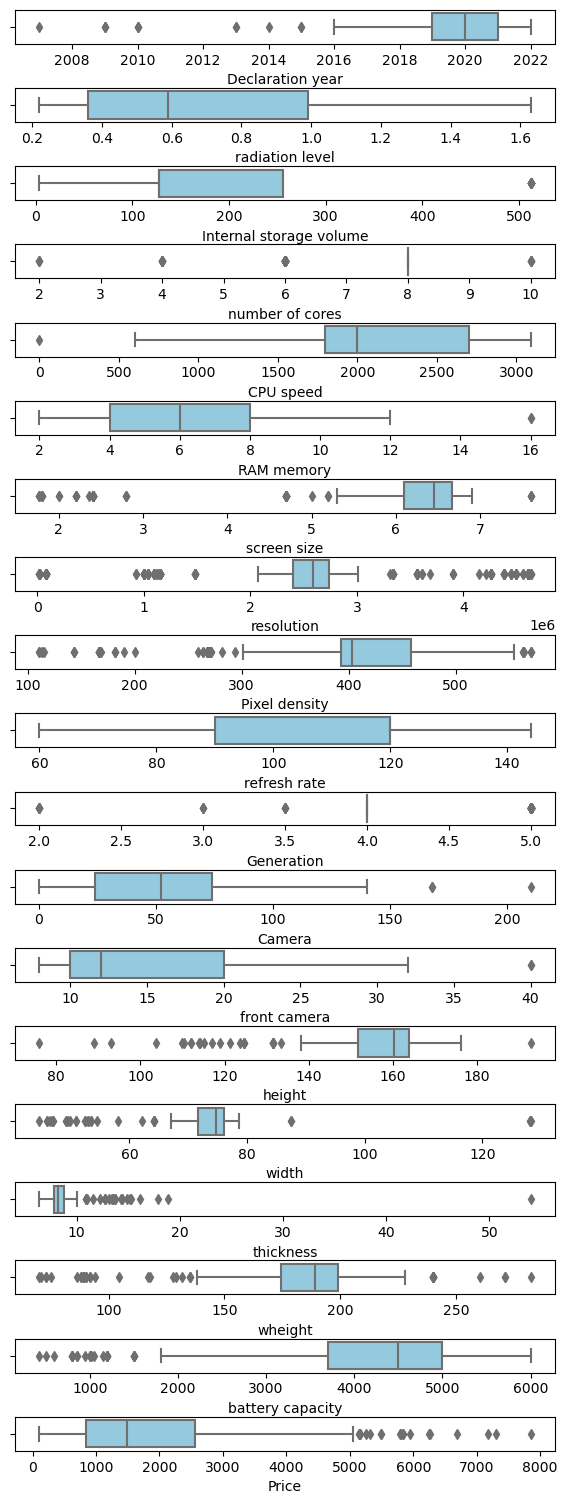

In [178]:
# Depiction of the Numericals variables in a graphical method
cols = NumericalData.columns
fig, ax = plt.subplots(len(cols),1, figsize = (6,15))
plt.tight_layout()

for i , col in enumerate(cols):
    sns.boxplot(data = NumericalData, x = col, ax = ax[i], color = 'skyblue')

Lets check all our catagoricals in a plt.

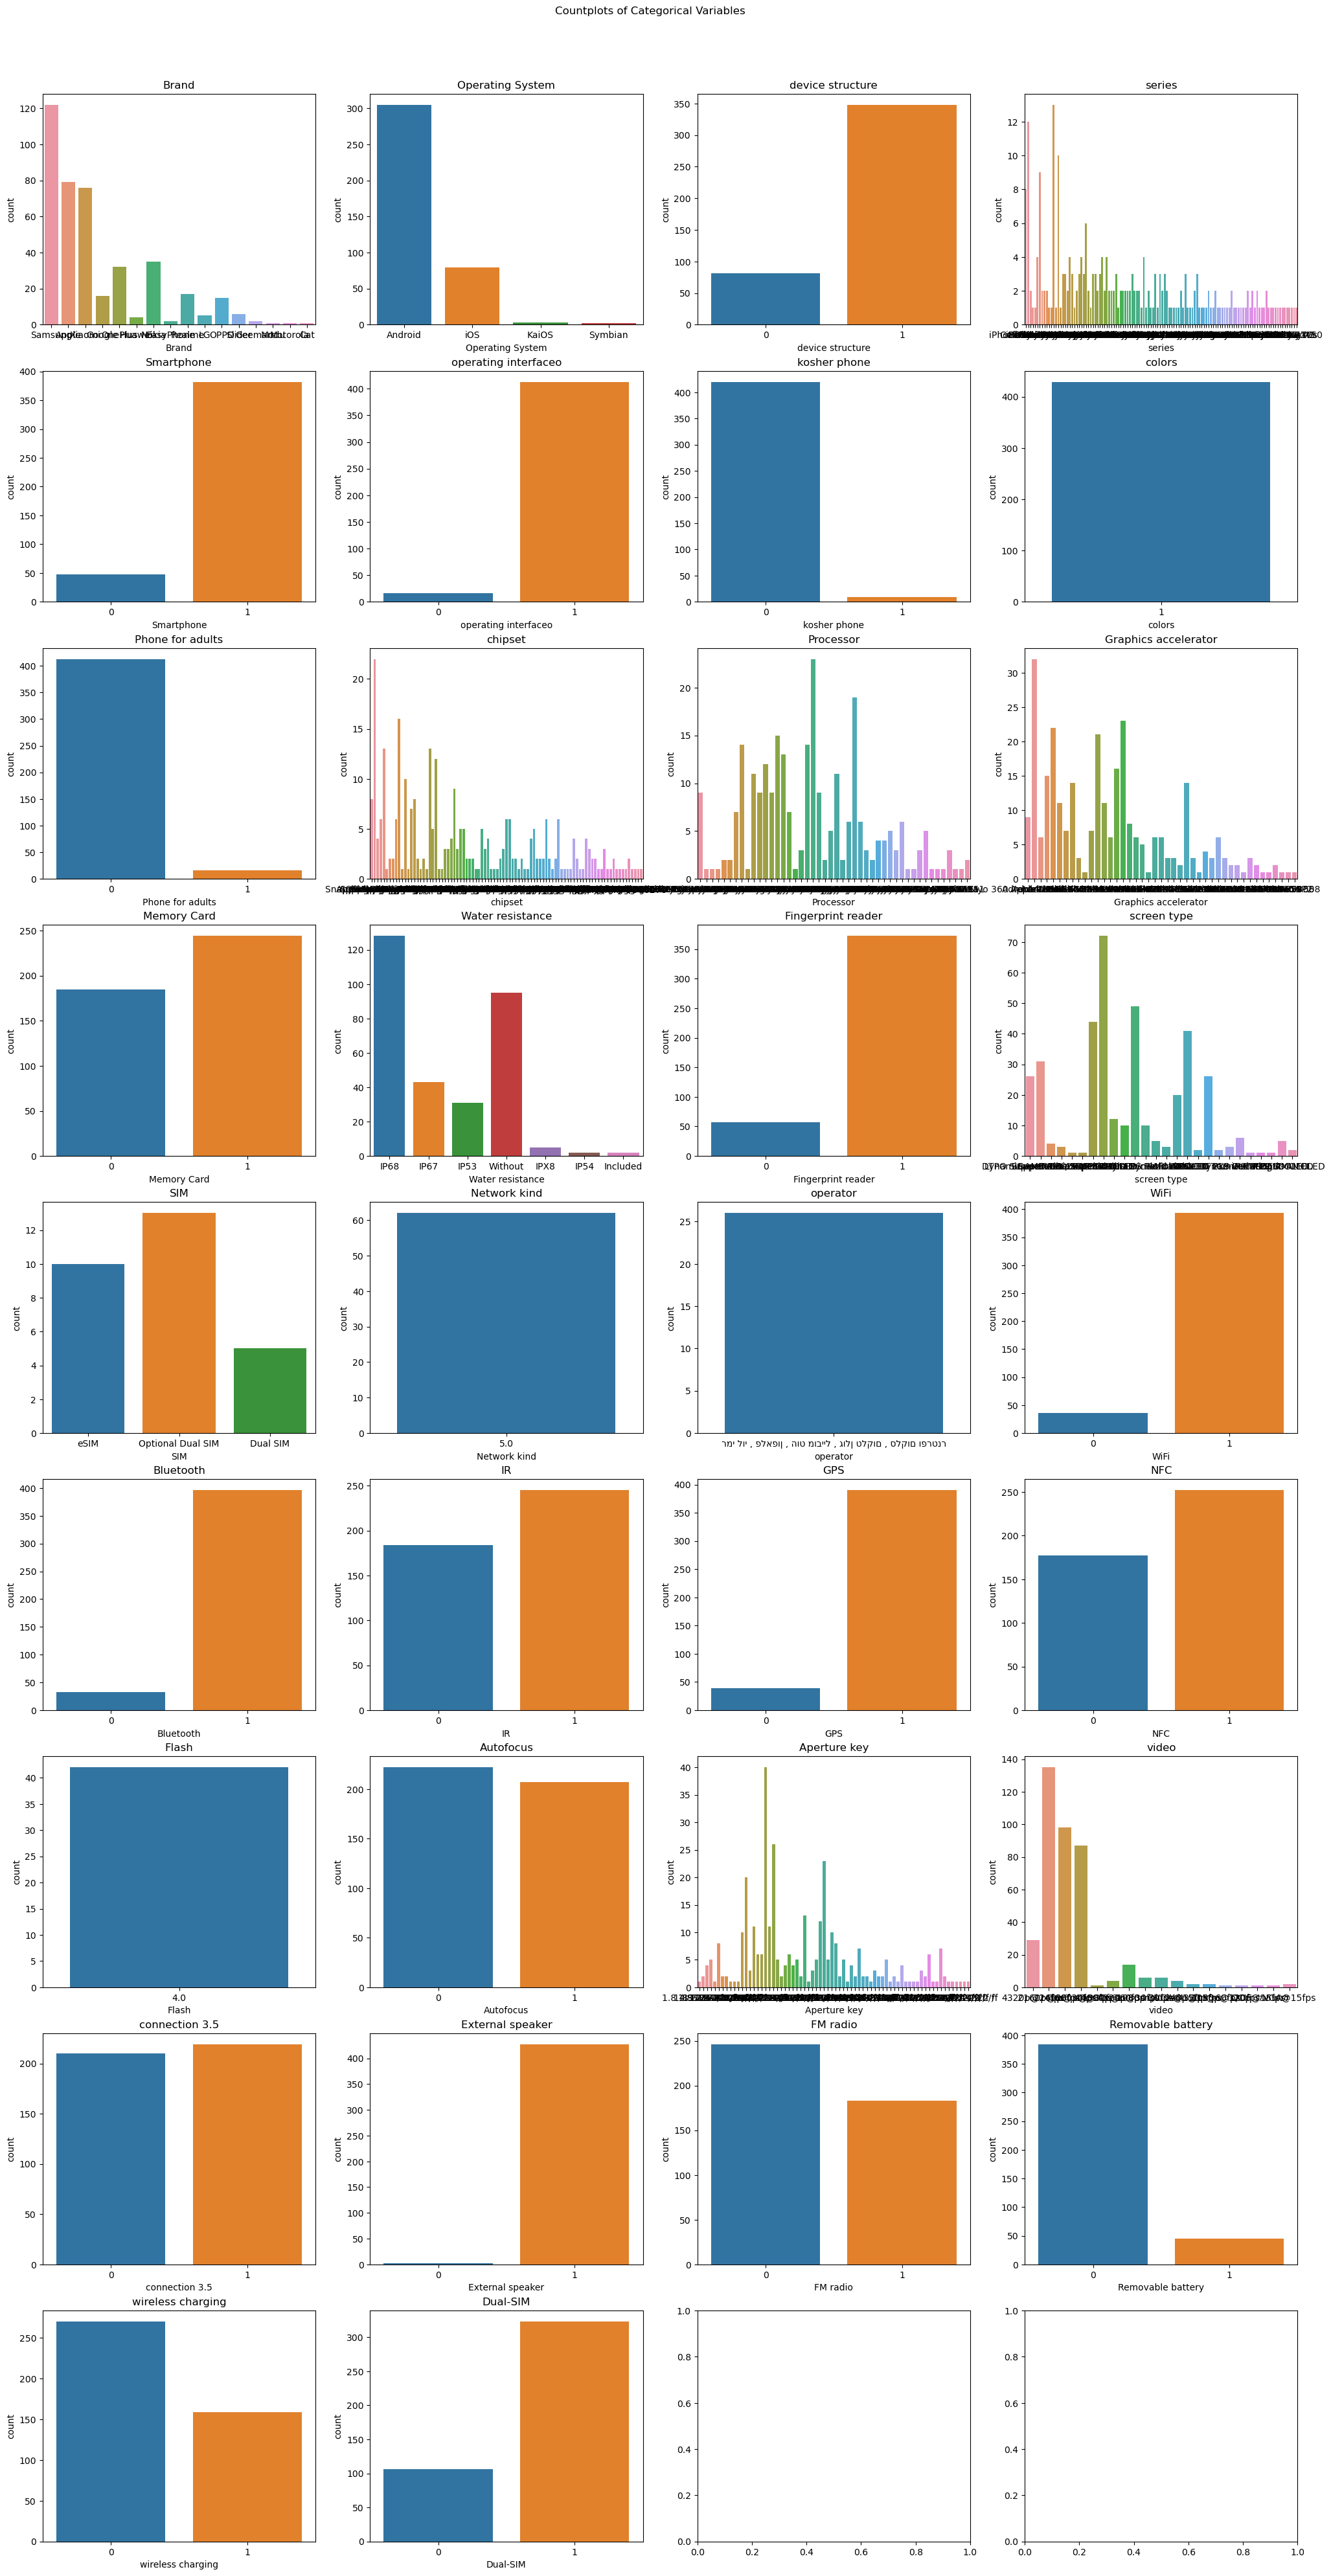

In [179]:
len(Categoricals)
n_plots = len(Categoricals)
n_cols = 4
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(25, 45))
ax = ax.flatten()
for i, col in enumerate(Categoricals):
    sns.countplot(x=dfUnionPrice[col], ax=ax[i])
    ax[i].set_title(col)
plt.subplots_adjust(top=0.95)
plt.suptitle("Countplots of Categorical Variables")
plt.show()


Looks like we got some data that are the same to all our phones and with a big ammount of NaN values, so we will drop them:

In [180]:
dfUnionPrice=dfUnionPrice.drop(['colors','Network kind','Flash','GPS'],axis=1)
Categoricals.remove('Network kind')
Categoricals.remove('colors')
Categoricals.remove('Flash')
Categoricals.remove('GPS')

Looks like we got some outliers but those outliers are ok accourding to our knowladge in this subject. so lets continue.
Lets check the ammount of NaN valus we have in some of our columns and see if we can save them.

In [181]:
nan_count = dfUnionPrice['SIM'].isnull().sum()
print('The ammount of NaN rows in the Declaration year column is:',nan_count)

The ammount of NaN rows in the Declaration year column is: 401


In [182]:
dfUnionPrice.drop('SIM',axis=1,inplace=True)
Categoricals.remove('SIM')

In [183]:
nan_count = dfUnionPrice['Declaration year'].isnull().sum()
print('The ammount of NaN rows in the Declaration year column is: ',nan_count)

The ammount of NaN rows in the Declaration year column is:  119


This ammout of NaN values is not high as 'SIM' but we still check if we can save them. Therefore lets see it in a plot.

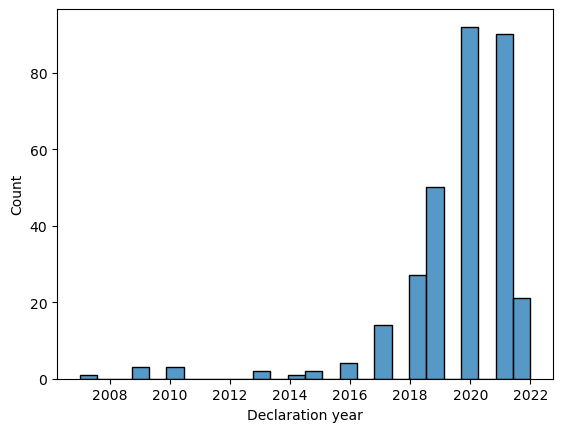

In [184]:
sns.histplot(dfUnionPrice['Declaration year'])
plt.show()

Looks like that most of the Phones are from the resent years. lets fill the missing rows with the meadian of this column.

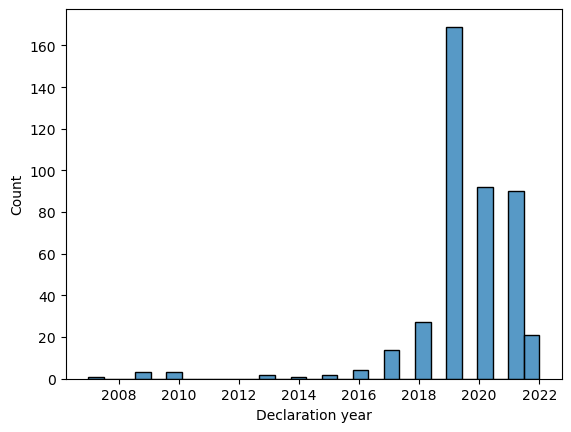

In [185]:
avgYear=int(dfUnionPrice['Declaration year'].mean())
dfUnionPrice['Declaration year']= dfUnionPrice['Declaration year'].fillna(avgYear)
sns.histplot(dfUnionPrice['Declaration year'])
plt.show()

In [186]:
nan_count = dfUnionPrice['CPU speed'].isnull().sum()
print('The ammount of NaN rows in the CPU speed column is: ',nan_count)

The ammount of NaN rows in the CPU speed column is:  156


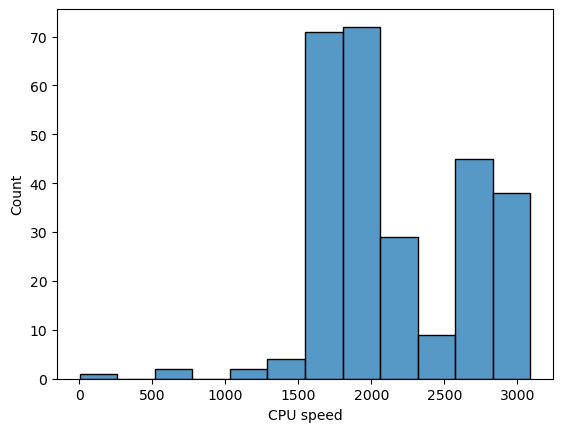

In [187]:
sns.histplot(dfUnionPrice['CPU speed'])
plt.show()


Lets do the same to 'CPU speed':

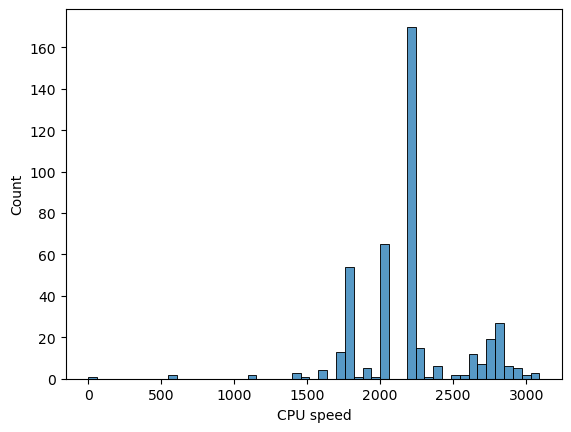

In [188]:
avgCPU=int(dfUnionPrice['CPU speed'].mean())
dfUnionPrice['CPU speed']= dfUnionPrice['CPU speed'].fillna(avgCPU)
sns.histplot(dfUnionPrice['CPU speed'])
plt.show()

In [189]:
nan_count = dfUnionPrice['front camera'].isnull().sum()
print('The ammount of NaN rows in the front camera column is: ',nan_count)

The ammount of NaN rows in the front camera column is:  400


We have to drop this column accourding to her high ammount of NaN.

In [190]:
dfUnionPrice.drop('front camera',axis=1,inplace=True)
Numericals.remove('front camera')

In [191]:
nan_count = dfUnionPrice['operator'].isnull().sum()
print('The ammount of NaN rows in the operator column is: ',nan_count)

The ammount of NaN rows in the operator column is:  403


In [192]:
dfUnionPrice.drop('operator',axis=1,inplace=True)
Categoricals.remove('operator')

In [193]:
nan_count = dfUnionPrice['number of cores'].isnull().sum()
print('The ammount of NaN rows in the number of cores column is: ',nan_count)

The ammount of NaN rows in the number of cores column is:  131


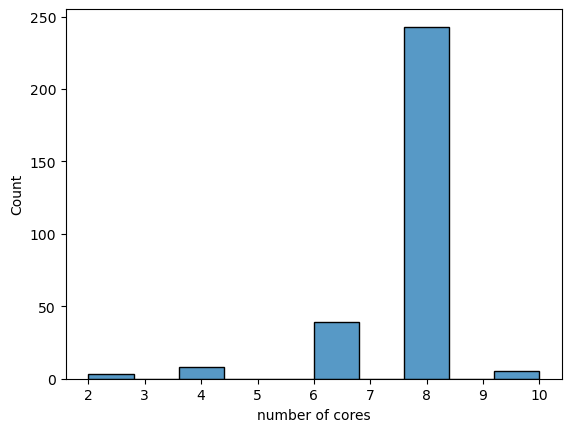

In [194]:
sns.histplot(dfUnionPrice['number of cores'])
plt.show()

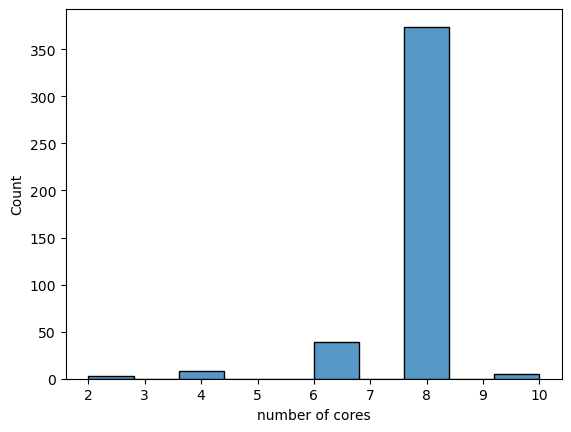

In [195]:
avgsotrage=dfUnionPrice['number of cores'].mode()[0]
dfUnionPrice['number of cores']= dfUnionPrice['number of cores'].fillna(avgsotrage)
sns.histplot(dfUnionPrice['number of cores'])
plt.show()

In [196]:
nan_count = dfUnionPrice['refresh rate'].isnull().sum()
print('The ammount of NaN rows in the refresh rate column is: ',nan_count)

The ammount of NaN rows in the refresh rate column is:  248


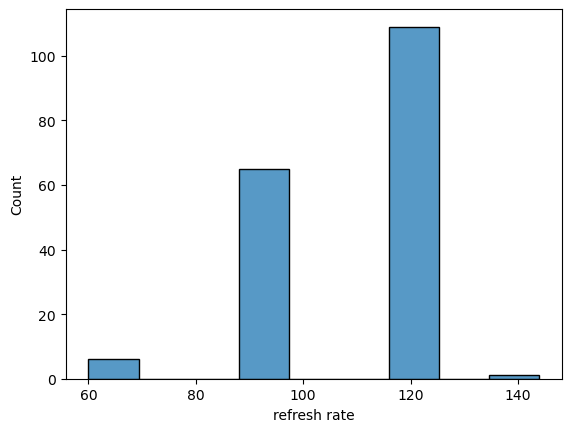

In [197]:
sns.histplot(dfUnionPrice['refresh rate'])
plt.show()

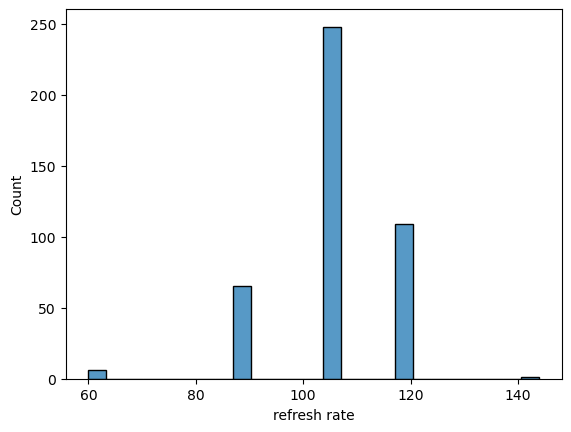

In [198]:
avgrefresh=int(dfUnionPrice['refresh rate'].mean())
dfUnionPrice['refresh rate']= dfUnionPrice['refresh rate'].fillna(avgrefresh)
sns.histplot(dfUnionPrice['refresh rate'])
plt.show()

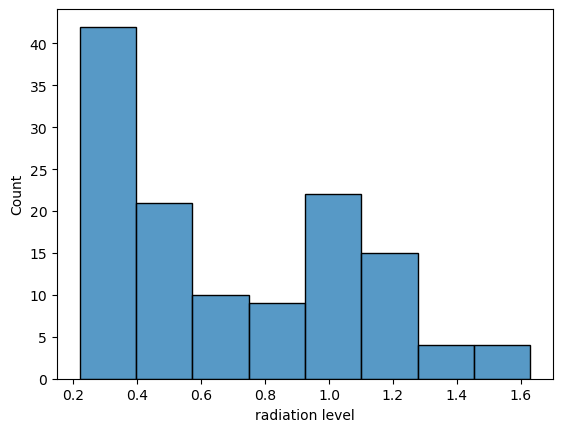

In [199]:
sns.histplot(dfUnionPrice['radiation level'])
plt.show()

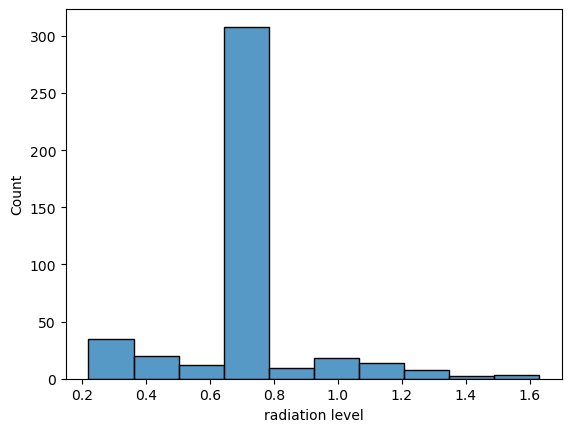

In [200]:
avgYear=dfUnionPrice['radiation level'].mean()
dfUnionPrice['radiation level']= dfUnionPrice['radiation level'].fillna(avgYear)
sns.histplot(dfUnionPrice['radiation level'])
plt.show()

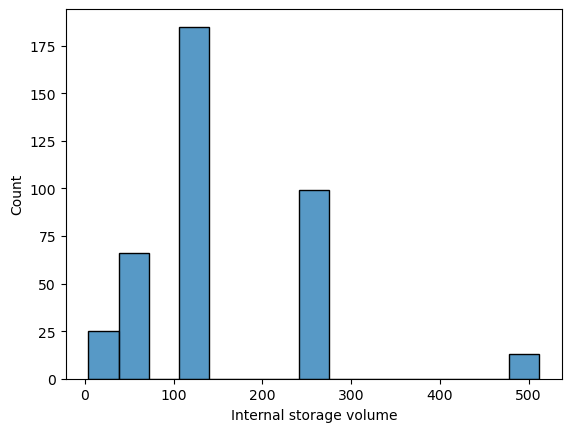

In [201]:
sns.histplot(dfUnionPrice['Internal storage volume'])
plt.show()

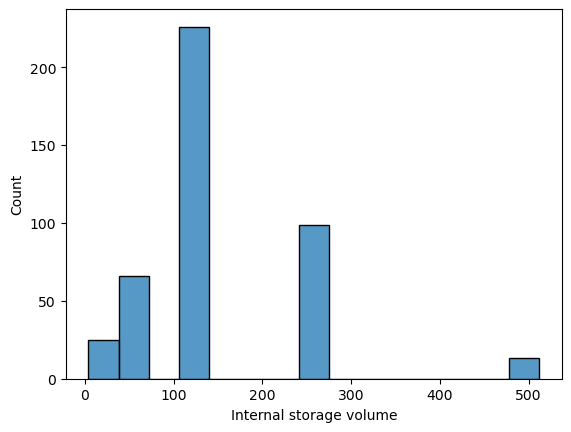

In [202]:
avgsotrage=dfUnionPrice['Internal storage volume'].mode()[0]
dfUnionPrice['Internal storage volume']= dfUnionPrice['Internal storage volume'].fillna(avgsotrage)
sns.histplot(dfUnionPrice['Internal storage volume'])
plt.show()

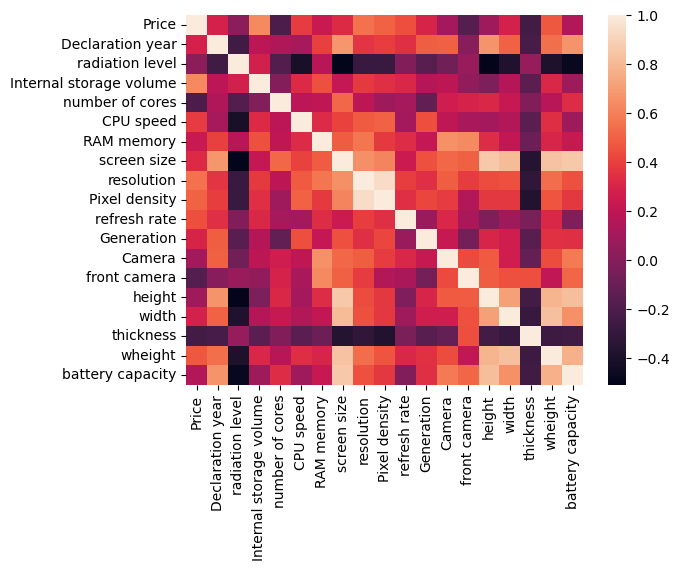

In [203]:
def create_heatmap(numeric_df):
    first_col = numeric_df.pop('Price')
    numeric_df.insert(0, 'Price', first_col)
    sns.heatmap(numeric_df.corr())
    
PhonesHeatmap = NumericalData.select_dtypes(include='number')
create_heatmap(PhonesHeatmap)

Depiction of the Numericals variables in a graphical method

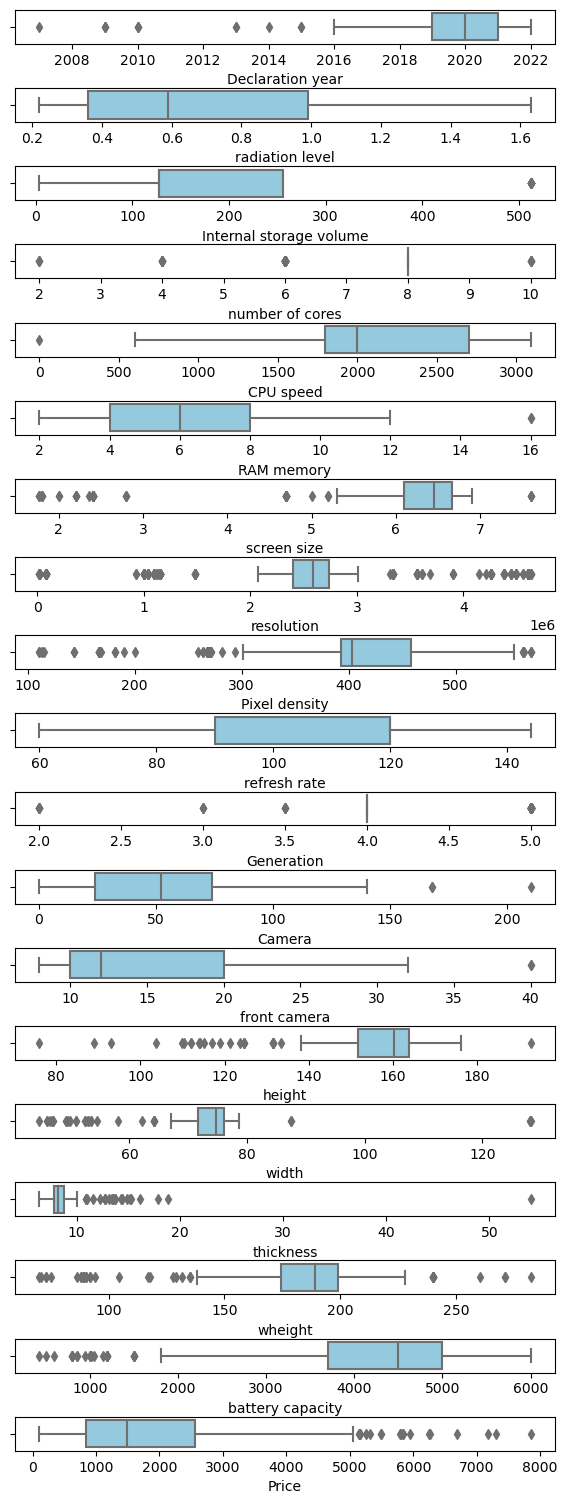

In [208]:

cols = NumericalData.columns
fig, ax = plt.subplots(len(cols),1, figsize = (6,15))
plt.tight_layout()

for i , col in enumerate(cols):
    sns.boxplot(data = NumericalData, x = col, ax = ax[i], color = 'skyblue')

Now lets check all the categorical columns that we have

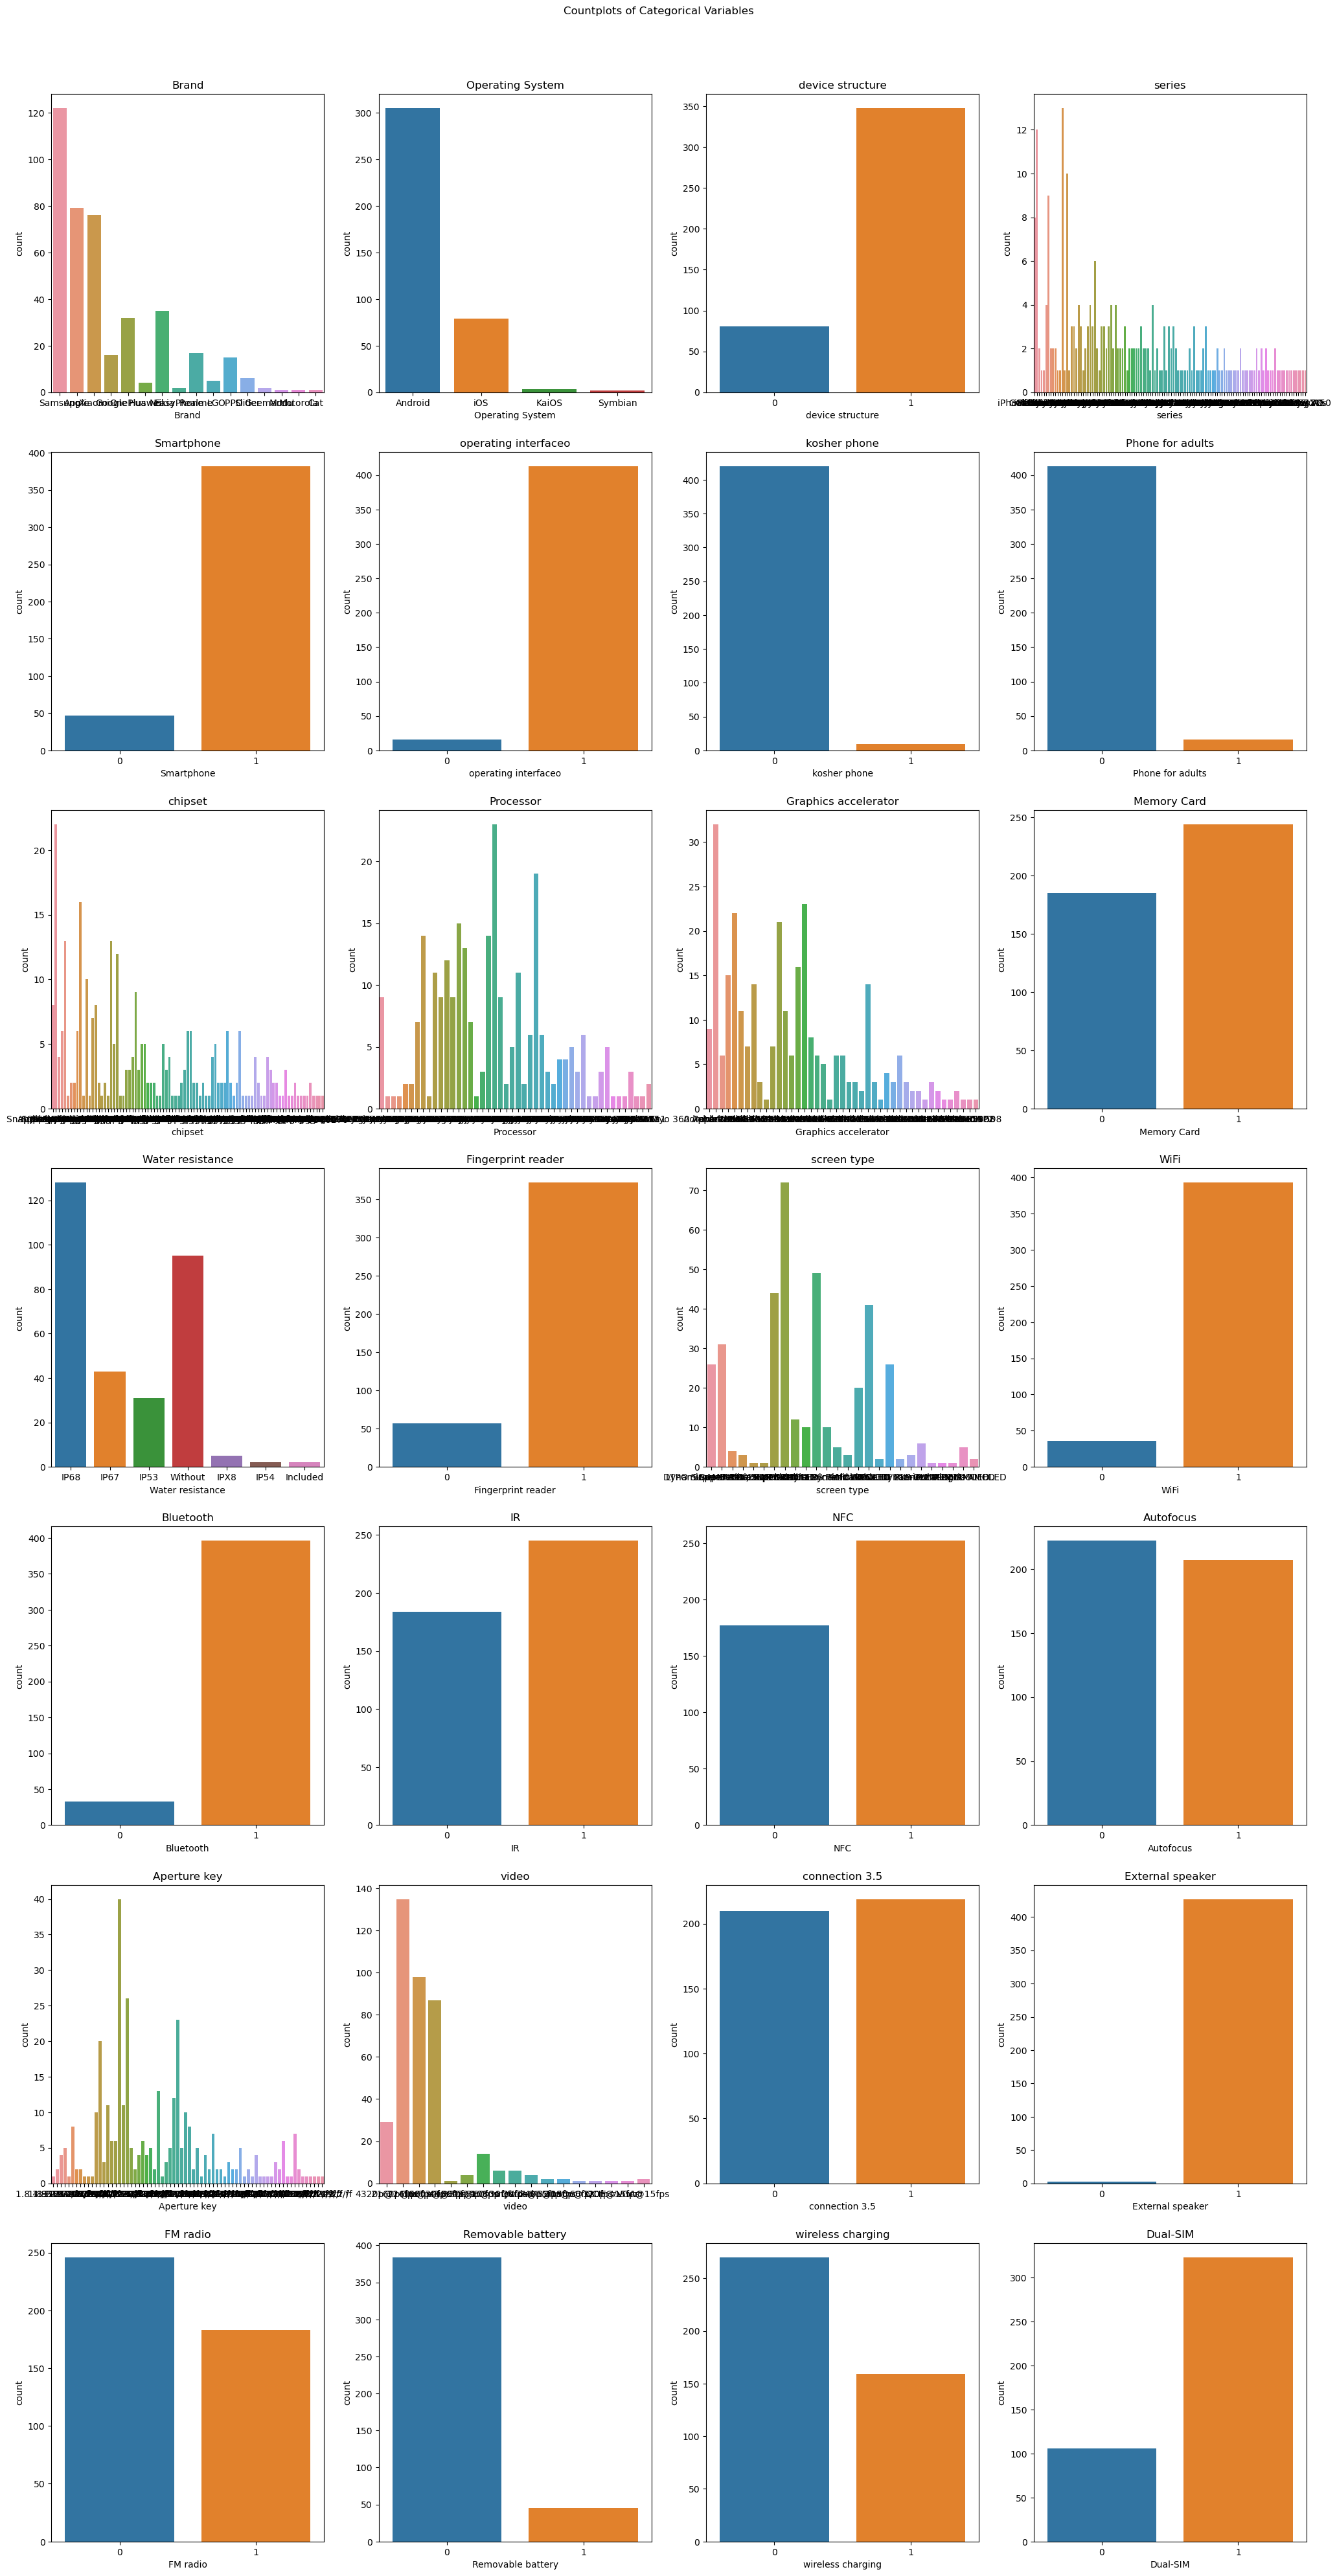

In [209]:
len(Categoricals)
n_plots = len(Categoricals)
n_cols = 4
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(25, 45))
ax = ax.flatten()
for i, col in enumerate(Categoricals):
    sns.countplot(x=dfUnionPrice[col], ax=ax[i])
    ax[i].set_title(col)
plt.subplots_adjust(top=0.95)
plt.suptitle("Countplots of Categorical Variables")
plt.show()


Lets check how the wheight effects on our mean Price:

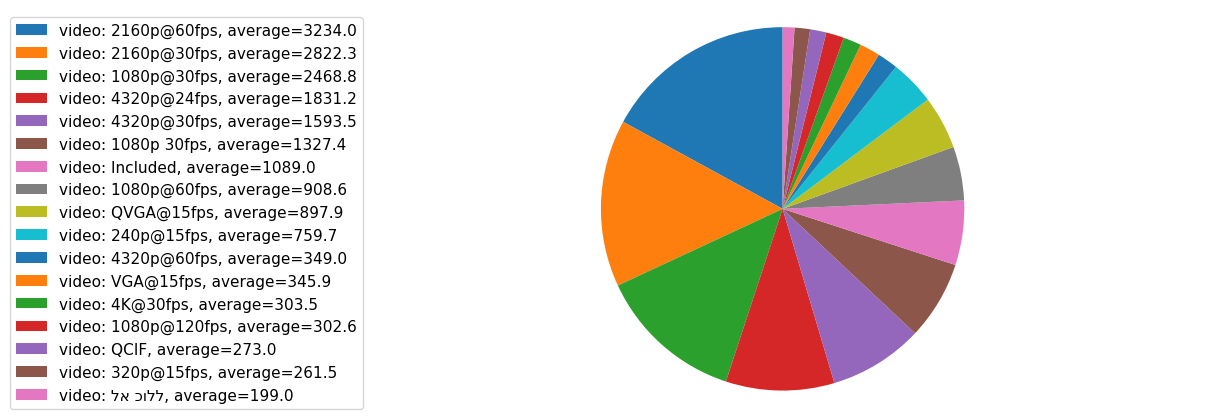

In [408]:
PhonesByProcessor_count = dfUnionPrice['Internal storage volume'].value_counts()

Phone_price_mean_by_Processor= dfUnionPrice.groupby('Internal storage volume', as_index=False)['Price'].mean()
Phone_price_mean_by_Processor.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Internal storage volume: %s" % i for i in PhonesByProcessor_count.index]

fig1, ax1 = plt.subplots(figsize=(12, 4))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(Phone_price_mean_by_Processor['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, Phone_price_mean_by_Processor.index, Phone_price_mean_by_Processor['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

Lets check how the Brand effects on our mean Price:

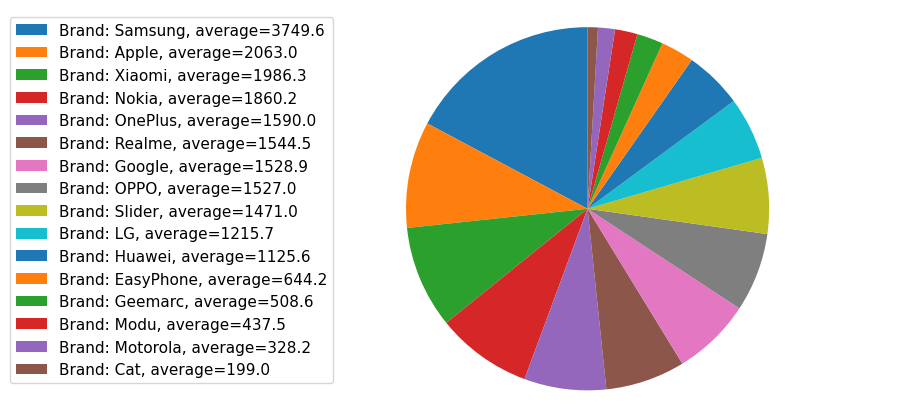

In [211]:
PhonesByProcessor_count = dfUnionPrice['Brand'].value_counts()

Phone_price_mean_by_Processor= dfUnionPrice.groupby('Brand', as_index=False)['Price'].mean()
Phone_price_mean_by_Processor.sort_values(by="Price", inplace=True, ascending=False)

labels = ["Brand: %s" % i for i in PhonesByProcessor_count.index]

fig1, ax1 = plt.subplots(figsize=(9, 4))
fig1.subplots_adjust(0.3,0,1,1)

_, _ = ax1.pie(Phone_price_mean_by_Processor['Price'].tolist(), startangle=90)

ax1.axis('equal')

plt.legend(
    loc='upper left',
    labels=['%s, average=%1.1f' % (
        l, (v)) for l, s, v in zip(labels, Phone_price_mean_by_Processor.index, Phone_price_mean_by_Processor['Price'].tolist())],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
)

plt.show()

The ammount of NaN before last dropna()

In [168]:
na_cols = dfUnionPrice.isna().sum()
print(dfUnionPrice.isna().sum().sum())
sumOfData=dfUnionPrice.shape[0]*dfUnionPrice.shape[1]
print(sumOfData)
dfUnionPrice.shape[1]

1477
19734


46

Now we want to chcek if we cleaned enough data, so we can predict the price

In [372]:
def train_model(X, y):
    reg = LinearRegression(fit_intercept = False)
    return reg.fit(X, y)

def evaluate_performance(y,y_predicted):
    return metrics.r2_score(y, y_predicted)

def split_to_X_and_y(df, target_column):
    return df.drop([target_column],axis = 1), df[target_column]

def predict(df):
    numeric_df = df.select_dtypes(include='number')
    X, y = split_to_X_and_y(numeric_df,'Price')
    trained_model = train_model(X, y)
    pred_vals = trained_model.predict(X)
    y_pred= pd.Series(pred_vals,index=X.index)
    eval_res = evaluate_performance(y, y_pred)
    print('amount of data:', X.shape[0] * X.shape[1])
    print('prediction:', eval_res)

In [409]:
first_try_df=dfUnionPrice.copy()
first_try_df.dropna(inplace=True)
predict(first_try_df)


amount of data: 4620
prediction: 0.8535298562731013


Its seems that we droped a lot of data... 
so we decided to go back to save more data

In [410]:
fix_df=dfUnionPrice.copy()
at_least_1_nan=fix_df.columns[fix_df.isna().any()].tolist()
at_least_1_nan

['Brand',
 'Operating System',
 'series',
 'chipset',
 'Processor',
 'Graphics accelerator',
 'RAM memory',
 'Water resistance',
 'screen size',
 'screen type',
 'resolution',
 'Pixel density',
 'Generation',
 'Camera',
 'Aperture key',
 'video',
 'height',
 'width',
 'thickness',
 'wheight',
 'battery capacity']

Okay,lets try to save some of those columns or drop the columns with big amount of nan

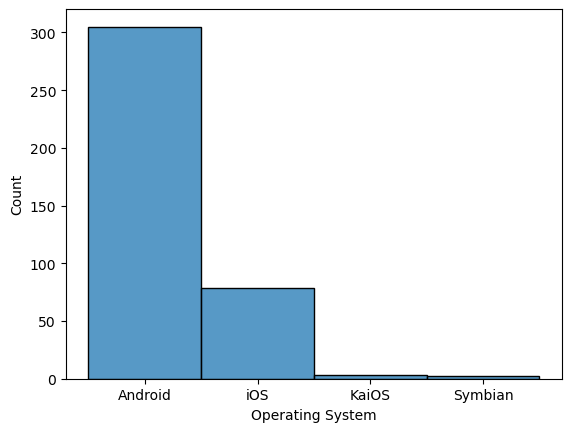

In [411]:
sns.histplot(fix_df['Operating System'])
plt.show()



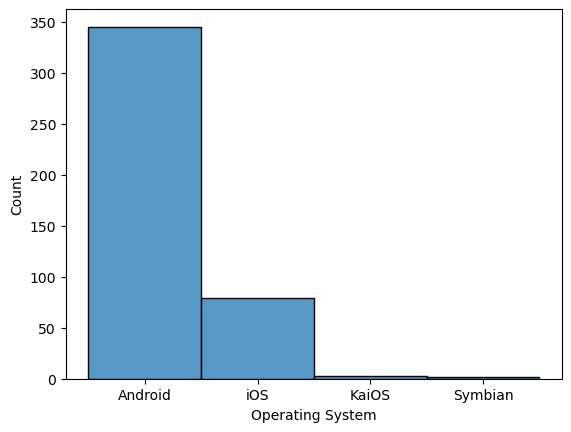

In [412]:
sys=fix_df['Operating System'].mode()[0]
fix_df['Operating System']=fix_df['Operating System'].fillna(sys)
sns.histplot(fix_df['Operating System'])
plt.show()

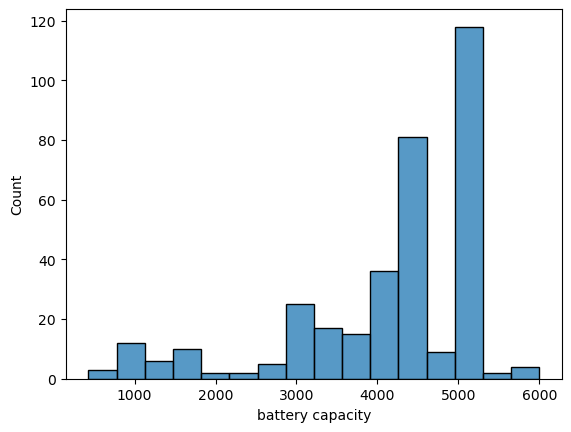

In [413]:
sns.histplot(fix_df['battery capacity'])
plt.show()


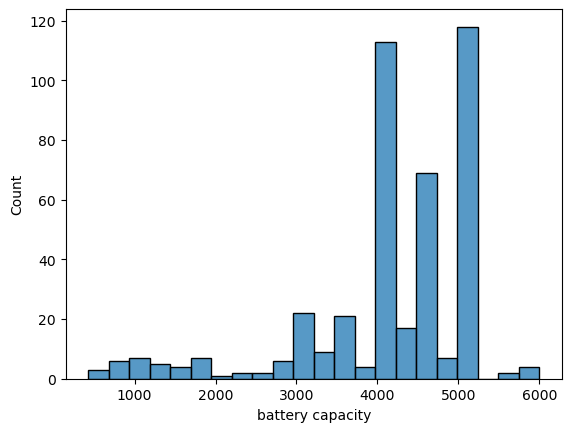

In [414]:
battery=int(fix_df['battery capacity'].mean())
fix_df['battery capacity']=fix_df['battery capacity'].fillna(battery)
sns.histplot(fix_df['battery capacity'])
plt.show()

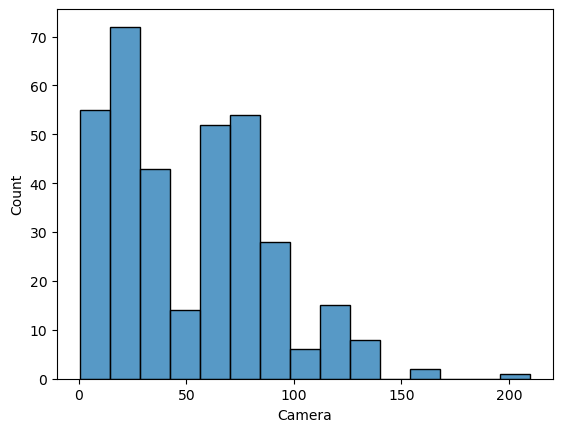

In [415]:
sns.histplot(fix_df['Camera'])
plt.show()

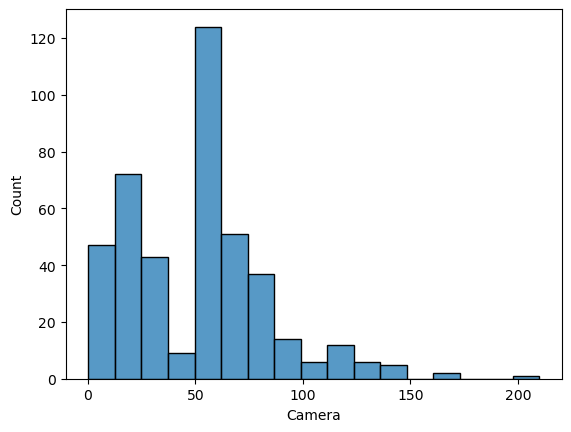

In [416]:
Camera=int(fix_df['Camera'].mean())
fix_df['Camera']=fix_df['Camera'].fillna(Camera)
sns.histplot(fix_df['Camera'])
plt.show()

In [417]:
series=fix_df['series'].isnull().sum()
chipset=fix_df['chipset'].isnull().sum()
screen_type=fix_df['screen type'].isnull().sum()
Water_resistance=fix_df['Water resistance'].isnull().sum()
Graphics_accelerator=fix_df['Graphics accelerator'].isnull().sum()
Processor=fix_df['Processor'].isnull().sum()
print('NaN count for those rows:\n''series: ',series,'\nscreen_type:',screen_type,'\nWater_resistance:',Water_resistance,'\nGraphics_accelerator:',Graphics_accelerator,'\nProcessor:',Processor,'\nchipset:',chipset)



NaN count for those rows:
series:  179 
screen_type: 48 
Water_resistance: 123 
Graphics_accelerator: 134 
Processor: 167 
chipset: 129


In [418]:
fix_df['screen type'].unique()


array(['Dynamic AMOLED 2X', 'Super Retina', 'LTPO Super Retina XDR OLED',
       'Super AMOLED Plus', 'Super Retina XDR OLED',
       'OLED , Super Retina', 'AMOLED', 'Super AMOLED', 'PLS LCD', 'OLED',
       nan, 'IPS', 'Dynamic AMOLED', 'Foldable Dynamic AMOLED 2X',
       'Retina IPS', 'Fluid AMOLED', 'IPS LCD', 'LCD', 'TFT',
       'Foldable Dynamic AMOLED', 'PLS IPS', 'P-OLED', 'Curved P-OLED',
       'PLS', 'Rotating P-OLED', 'LTPO AMOLED', 'Optic AMOLED'],
      dtype=object)

Its look we have a lot of data in screen type column so we decided not to drop this column but rather to fill the nan with a "junk values"


In [419]:
fix_df['screen type'].fillna("junk values",inplace=True)

In [422]:
fix_df=fix_df.drop(['series','chipset','Processor','Graphics accelerator','Water resistance'],axis=1)
sumOfData=fix_df.shape[0]*fix_df.shape[1]
print(sumOfData)
fix_df.dropna(inplace=True)
sumOfData=fix_df.shape[0]*fix_df.shape[1]
print(sumOfData)

17589
11685


In [423]:
PhonesMechine=fix_df.copy()
predict(PhonesMechine)


amount of data: 9975
prediction: 0.851863545019335
